In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
### YOUR CODE HERE
# Figure out how to import regularizers
###
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np 

In [8]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

--2020-07-27 17:04:07--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.167.128, 64.233.166.128, 173.194.76.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.167.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2020-07-27 17:04:07 (78.7 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [12]:
model = Sequential([
    tf.keras.layers.Embedding(total_words, 100, input_length = max_sequence_len - 1),
    tf.keras.layers.Bidirectional(LSTM(150, return_sequences = True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(LSTM(150)),
    tf.keras.layers.Dense(total_words/2, kernel_regularizer = regularizers.l2(0.01), activation = 'relu'),
    tf.keras.layers.Dense(total_words, activation = 'softmax')
])
# model.add(# Your Embedding Layer)
# model.add(# An LSTM Layer)
# model.add(# A dropout layer)
# model.add(# Another LSTM Layer)
# model.add(# A Dense Layer including regularizers)
# model.add(# A Dense Layer)
# Pick an optimizer
model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 10, 100)           321100    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 10, 300)           301200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 300)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 300)               541200    
_________________________________________________________________
dense (Dense)                (None, 1605)              483105    
_________________________________________________________________
dense_1 (Dense)              (None, 3211)              5156866   
Total params: 6,803,471
Trainable params: 6,803,471
Non-trainable params: 0
______________________________________________

In [13]:
 history = model.fit(predictors, label, epochs=100, verbose=1)

Epoch 1/100
484/484 [==============================] - 16s 33ms/step - loss: 7.0185 - accuracy: 0.0200
Epoch 2/100
484/484 [==============================] - 16s 33ms/step - loss: 6.5104 - accuracy: 0.0223
Epoch 3/100
484/484 [==============================] - 16s 33ms/step - loss: 6.4234 - accuracy: 0.0228
Epoch 4/100
484/484 [==============================] - 16s 33ms/step - loss: 6.3104 - accuracy: 0.0282
Epoch 5/100
484/484 [==============================] - 16s 33ms/step - loss: 6.1932 - accuracy: 0.0359
Epoch 6/100
484/484 [==============================] - 16s 33ms/step - loss: 6.0993 - accuracy: 0.0417
Epoch 7/100
484/484 [==============================] - 16s 33ms/step - loss: 6.0024 - accuracy: 0.0417
Epoch 8/100
484/484 [==============================] - 16s 34ms/step - loss: 5.8978 - accuracy: 0.0461
Epoch 9/100
484/484 [==============================] - 16s 33ms/step - loss: 5.7811 - accuracy: 0.0521
Epoch 10/100
484/484 [==============================] - 16s 33ms/step - l

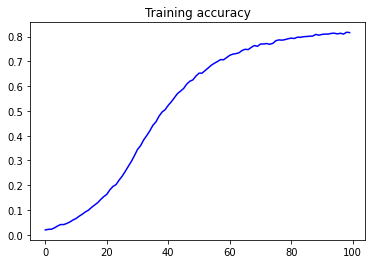

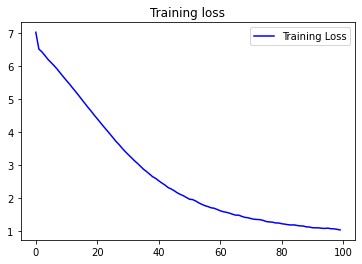

In [14]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [15]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Help me Obi Wan Kenobi, you're my only hope to his living report best ' still live here ' must live so forth so o'er more strong shame rare go wide age of well shows thy worth so lies now thee resort foes grow cold dearer dearer dearer best best ' ' ' must say youth it in such living wrong ' still inhearse hence quite about about latch word must live ' ' ' still write so so great old dear eye ' and well took weeds moan sits equipage ground wind shines new ' are torn days affords bow go wrong ' still ' still live more
